In [20]:
import networkx as nx
import sklearn
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from gensim.models import Word2Vec
import numpy as np
import itertools
import random

In [21]:

class DeepWalk(object):
    def __init__(self, graph, walk_length, num_walks, walkers=1, verbose=0, random_state=None, large_data=False):
        self.G = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.walkers = walkers
        self.verbose = verbose
        self.w2v = None
        self.embeddings = None
        self.random_state = random_state if random_state else 2022
        self.dataset = self.get_train_data(walk_length, num_walks, workers=walkers)

    def fit(self, embed_size=128, window=5, n_jobs=3, epochs=5, **kwargs):
        kwargs['sentences'] = self.dataset
        kwargs['min_count'] = kwargs.get('min_count', 0)
        kwargs['vector_size'] = embed_size
        kwargs['sg'] = 1  # skipgram
        kwargs['hs'] = 1  # hierarchy softmax
        kwargs['workers'] = n_jobs
        kwargs['window'] = window
        kwargs['epochs'] = epochs
        kwargs['seed'] = self.random_state

        self.w2v = Word2Vec(**kwargs)


    def get_train_data(self, walk_length, num_walks, workers=1, verbose=0):

        if num_walks % workers == 0:
            num_walks = [num_walks // workers] * workers
        else:
            num_walks = [num_walks // workers] * workers + [num_walks % workers]

        nodes = list(self.G.nodes())    

        results = Parallel(n_jobs=workers, verbose=verbose)(
            delayed(self.simulate_walks)(nodes, num, walk_length) for num in num_walks
        )

        dataset = list(itertools.chain(*results))
        return dataset

    
    def simulate_walks(self, nodes, num_walks, walk_length):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                walks.append(self.deep_walk(walk_length=walk_length, start_node=v))
        return walks

    def deep_walk(self, walk_length, start_node):
        
        G = self.G

        walk = [start_node]

        while len(walk) < walk_length:
            current_node = walk[-1]
            current_neighbors = list(G.neighbors(current_node))
            if len(current_neighbors) > 0:
                walk.append(random.choice(current_neighbors))
            else:
                break
        return walk

    def get_embeddings(self):
        if self.w2v:
            self.embeddings = {}
            for node in self.G.nodes():
                self.embeddings[node] = self.w2v.wv[node]
            return self.embeddings
        else:
            print("Please train the model first")
            return None

In [22]:
graph = nx.read_edgelist("/home/nobertai/repo/ControlFlowAnalyzer/data/_home_nobertai_htdocs_wordpress_wp-admin_install_php/edge.nx")

In [23]:
dw = DeepWalk(graph, 5, 10000, walkers=12, verbose=0, random_state=2022)

In [24]:
dw.fit()

In [25]:
embed = dw.get_embeddings()

In [26]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20)


def downgrading_embeddings(embeds):
    t_SNE = TSNE(n_components=2, init="pca", random_state=2022)
    labels = []
    embed_ls = []
    for key, val in embeds.items():
        labels.append(key)
        embed_ls.append(val)
        
    nodes_pos = t_SNE.fit_transform(embed_ls)
    return nodes_pos


def plot_embeddings(embeds):
    
    t_SNE = TSNE(n_components=2, init="pca", random_state=2022)
    labels = []
    embed_ls = []
    for key, val in embeds.items():
        labels.append(key)
        embed_ls.append(val)
        
    nodes_pos = t_SNE.fit_transform(embed_ls)
    
    
    for i, (label, pos) in enumerate(zip(labels, nodes_pos)):
        plt.scatter(pos[0], pos[1], label=label)
        # plt.annotate(label, (pos[0], pos[1]))
        plt.text(pos[0]+0.15, pos[1]+0.15, label, fontsize=14)
    
    # plt.legend(bbox_to_anchor = (1.05, 1))
    plt.show()
    

def clustering_kmeans(X, n_clusters=2, title=""):
    
    y_pred = KMeans(n_clusters=n_clusters, random_state=2022).fit_predict(X)
    plt.scatter(X[:,0], X[:,1], c=y_pred)
    plt.title(title)
    plt.show()
    
    
    
    
    

/home/nobertai/pyenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nobertai/pyenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


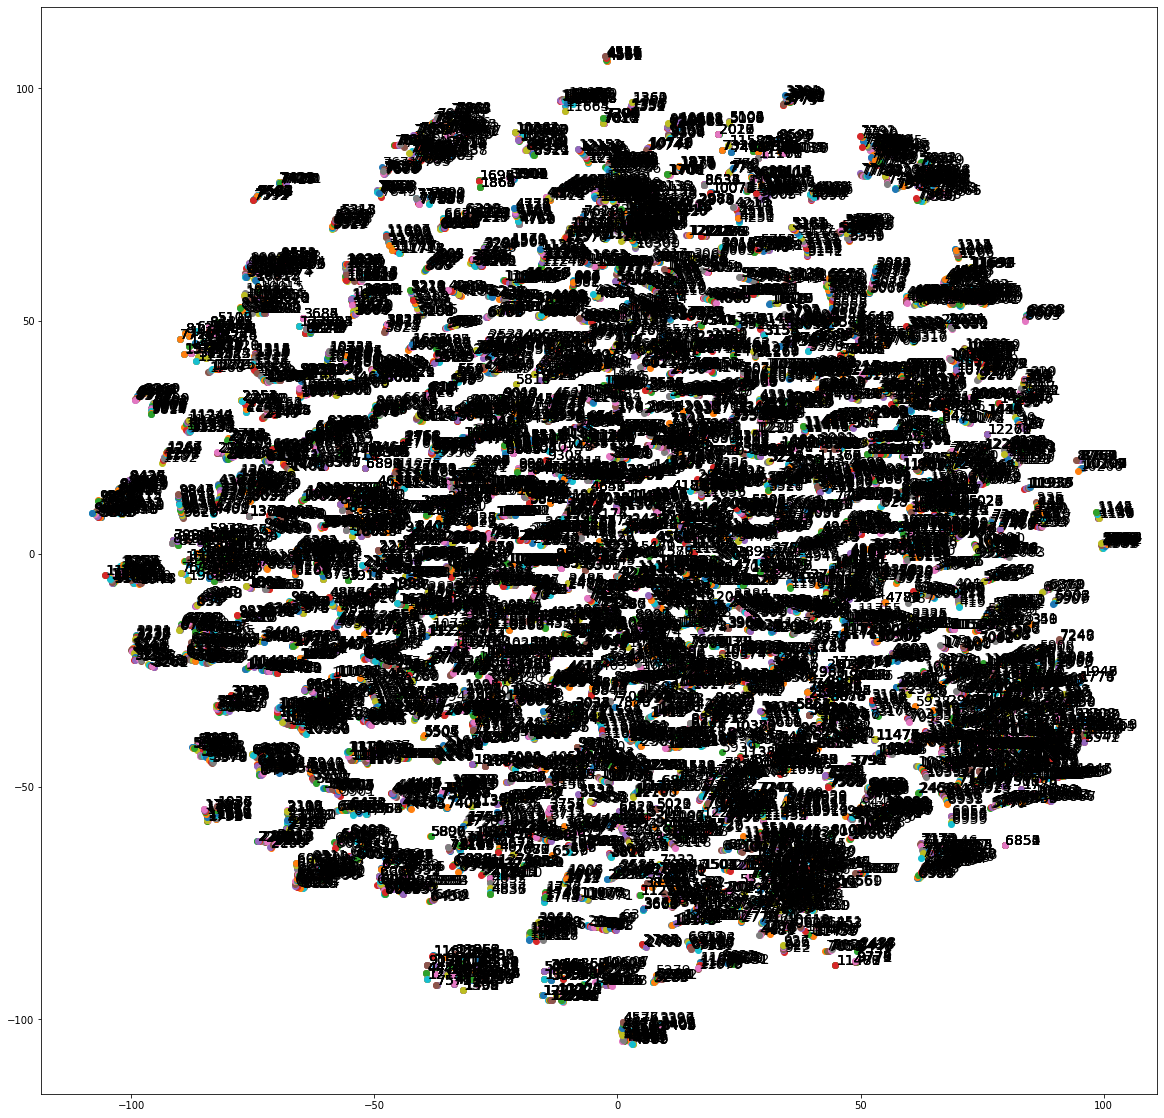

In [27]:
plot_embeddings(embed)

# K mean clustering

/home/nobertai/pyenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nobertai/pyenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


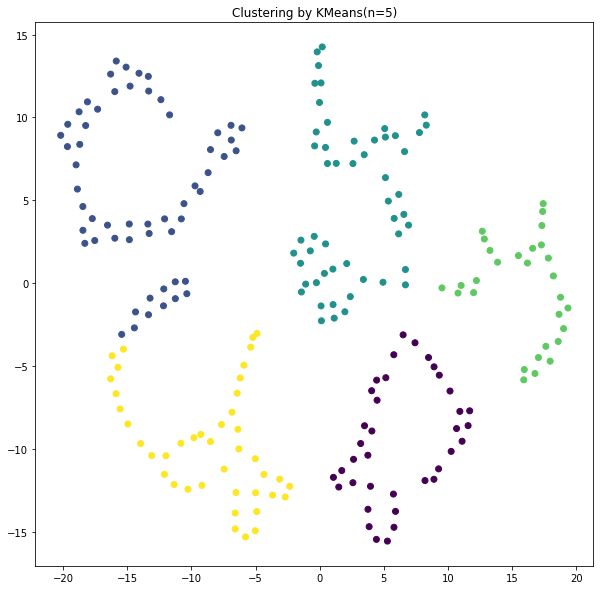

In [9]:
plt.rcParams["figure.figsize"] = (10, 10)
X = downgrading_embeddings(embed)
clustering_kmeans(X, n_clusters=5, title="Clustering by KMeans(n=5)")

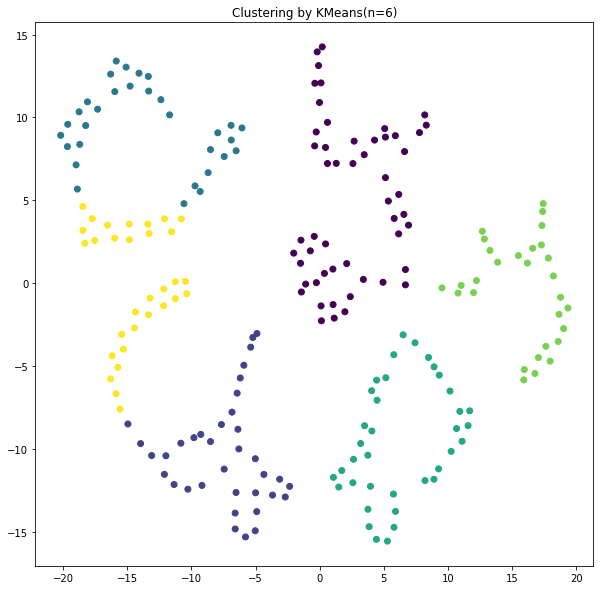

In [10]:
clustering_kmeans(X, n_clusters=6, title="Clustering by KMeans(n=6)")

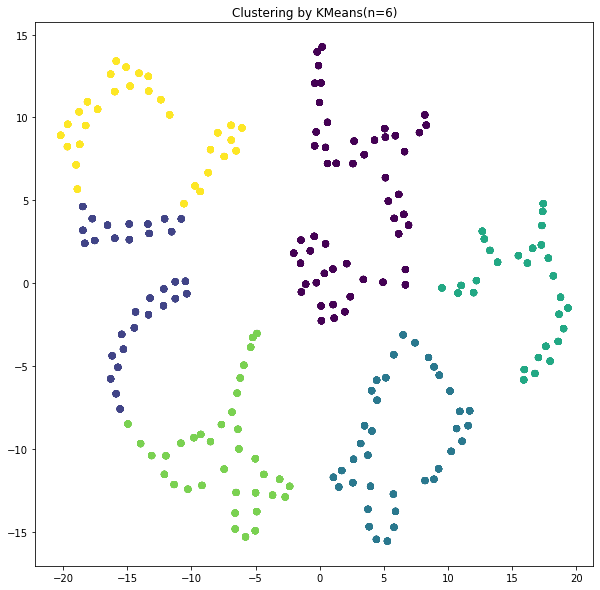

In [11]:
XX = np.concatenate([X for i in range(20)], axis=0)
clustering_kmeans(XX, n_clusters=6, title="Clustering by KMeans(n=6)")

# The test of mean shift

In [12]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import numpy as np

def clustering_ms(X):
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=100)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)

    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    print("number of estimated clusters: %d" % n_clusters_)
    plt.scatter(X[:, 0], X[:, 1], label=labels, c=labels)
        
    plt.plot(cluster_centers[:,0], cluster_centers[:,1], "o", markerfacecolor="k", markeredgecolor="k", markersize=14)
    
    plt.show()
    
    

/home/nobertai/pyenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nobertai/pyenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


number of estimated clusters: 4


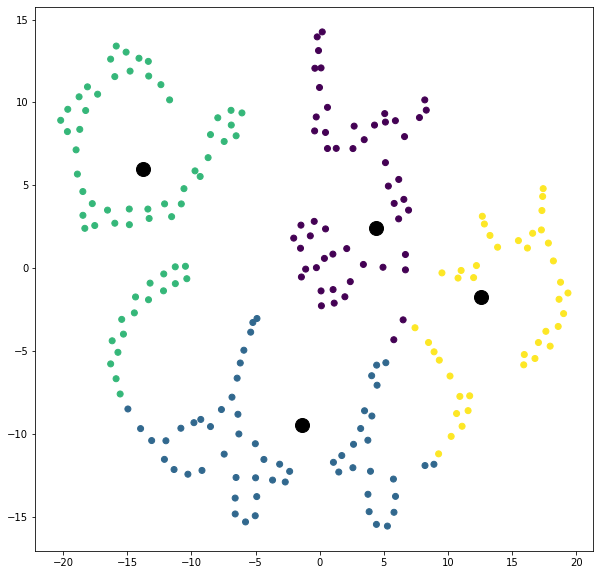

In [13]:
X = downgrading_embeddings(embed)
clustering_ms(X)

# DBSCAN

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


def clustering_dbs(X):
    
    X = StandardScaler().fit_transform(X)
    
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    # print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
    
    y_pred = DBSCAN(eps=0.3, min_samples=10).fit_predict(X)
    
    plt.scatter(X[:, 0], X[:,1], c=y_pred)
    
    plt.show()
    
    


Estimated number of clusters: 8
Estimated number of noise points: 106


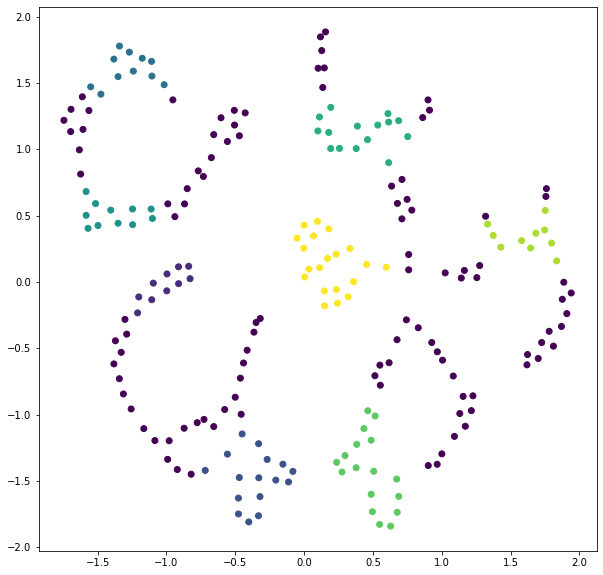

In [15]:
clustering_dbs(X)

# Double the datapoint